# Reasoning LLMs

In [1]:
# warning control
import warnings
warnings.filterwarnings("ignore")

from utils import *

### Why Reasoning LLMs?

Chain-of-thought (CoT) is the prompting method used for eliciting reasoning (system 2 thinking) in LLMs. 

#### Scaling Performance
- More recent LLMs scale test-time compute (i.e., more compute at inference) to enable native CoT out of the box. 
- The more compute the model is given and the more time it's allowed to "reason" or "think", the better the chanced to improve results on the task. This leads to scaling the LLM performance on a wider range of tasks.


#### Performance

- While native CoT (with models like o1 and o3) helps to significantly improve performance, it's not suited for all tasks. We will share tips along the way and discuss suitable use cases. We will also discuss when to combine native CoT and manual CoT.
- Reasoning models like o1 perform well on tasks like maths, coding, science, strategy, deep analysis, complex logistics, and multi-step planning for agentic workflows (e.g., OpenAI Deep Research). 
- These models have been trained with the ability to self-correct, try different strategies, and automatically breaking problems down to simpler steps. 

#### OpenAI Available Reasoning Models

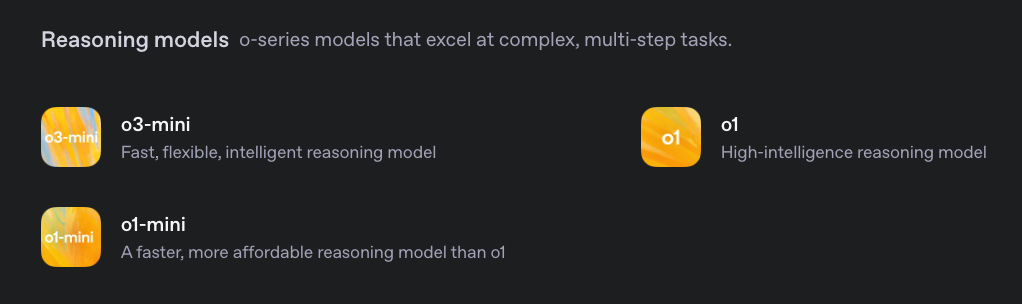

Find cost and related information to the models on the official model page: https://platform.openai.com/docs/models



### First Basic Example

In [2]:
prompt = """
Write a bash script that takes a matrix represented as a string with 
format '[1,2],[3,4],[5,6]' and prints the transpose in the same format.
"""

response = client.chat.completions.create(
    model="o3-mini",
    reasoning_effort="medium",
    messages=[
        {
            "role": "user", 
            "content": prompt
        }
    ]
)

print(response.choices[0].message.content)

Below is one way to solve the problem. In this example the script accepts the matrix string as its first argument. It then “splits” the string into rows, parses the comma‐separated numbers for each row, and finally prints the transpose (switching rows with columns) in the same format.

Save the following script (for example as transpose.sh), give it execute permission (chmod +x transpose.sh), and run it by passing the matrix string as an argument.

------------------------------------------------------------
#!/bin/bash
#
# Example usage:
#   ./transpose.sh "[1,2],[3,4],[5,6]"
#

# Ensure we got one argument.
if [ "$#" -ne 1 ]; then
    echo "Usage: $0 \"[1,2],[3,4],[5,6]\""
    exit 1
fi

matrix_input="$1"

# Step 1. Replace the '],[' delimiter with a newline
# Also remove any leading '[' and trailing ']' characters.
rows=$(echo "$matrix_input" | sed 's/\],\[/\n/g' | sed 's/^\[//' | sed 's/\]$//')

# Read the rows into an array (each element is a comma-separated row)
readarray -t matr

Let's review manual CoT:

In [3]:
menu_delimiter = "<menu_items>"
menu_delimiter_end = "</menu_items>"

thinking_delimiter = "<thinking>"
thinking_delimiter_end = "</thinking>"

response_delimiter = "<response>"
response_delimiter_end = "</response>"

menu_delimiter = "<menu_items>"
menu_delimiter_end = "</menu_items>"

thinking_delimiter = "<thinking>"
thinking_delimiter_end = "</thinking>"

response_delimiter = "<response>"
response_delimiter_end = "</response>"

food_items = get_menu_items()

system_message = f"""
Your task is answer questions factually about a food menu, provided below and delimited by {menu_delimiter}{menu_delimiter_end}.

Step 1: The first step is to check if the user is asking a question related to any type of food (even if that food item is not on the menu). If the question is about any type of food, we move on to Step 2 and ignore the rest of Step 1. If the question is not about food, then we send a response: "Sorry! I cannot help with that. Please let me know if you have a question about our food menu."

Step 2: In this step, we check that the user question is relevant to any of the items on the food menu. You should check that the food item exists in our menu first. If it doesn't exist then send a kind response to the user that the item doesn't exist in our menu and then include a list of available but similar food items without any other details (e.g., price). The food items available are provided below and delimited by {menu_delimiter}{menu_delimiter_end}:

{menu_delimiter}
{food_items}
{menu_delimiter_end}

Step 3: If the item exist in our food menu and the user is requesting for specific information, provide that relevant information to the user using the food menu. Make sure to use a friendly tone and keep the response concise.

Perform the following reasoning steps to send a response to the user:
{thinking_delimiter}
Step 1: <Step 1 reasoning>
Step 2: <Step 2 reasoning>
{thinking_delimiter_end}
{response_delimiter}
Response to the user: <response to user>
{response_delimiter_end}
"""

user_message = "What is the price of the Mini Cheeseburger?"

messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_message}
]

response = get_chat_completion(messages, model="gpt-4o")
print(response)

<thinking>
Step 1: The user is asking a question related to a food item, specifically the Mini Cheeseburger.
Step 2: The Mini Cheeseburger is listed in the Kids Menu section of our food menu.
</thinking>
<response>
Response to the user: The price of the Mini Cheeseburger is $6.99.
</response>


Let's convert that example into native CoT:

In [4]:
instructions = f"""Your task is answer questions factually about a food menu, provided below and delimited by {menu_delimiter}{menu_delimiter_end}.
{menu_delimiter}
{food_items}
{menu_delimiter_end}
"""
user_message = "What is the price of the Mini Cheeseburger?"

messages = [
    {"role": "developer", "content": instructions},
    {"role": "user", "content": user_message}
]

# users new get_reasoning_response function
# low, medium, or high can be used for reasoning efforts
response = get_reasoning_response(messages, model="o3-mini", reasoning_effort="low")
print(response)

The Mini Cheeseburger is priced at $6.99.


### Usage & Prompting Tips

- You can use different reasoning efforts options such as `low` for lower costs and faster responses or `high` for higher thinking time and more tokens which also results on slower responses. `medium` is a balance between accuracy and speed.

- The `developer` message serve as the new system message for reasoning models starting with `o1-2024-12-17`.

- Keep the instructions simple and direct. Provide clear goals, prompt the model to keep reasoning to meet your needs, and add your response constraints in the instructions whenever applicable. 

- Don't use chain-of-thought, step-by-step, instructions. 

- Continue using delimiters with reasoning models.

- Add few-shot demonrations/exemplars if you need to meet a desired output that the model is struggling with. Make sure to align these with your high-level instructions to avoid confusion.

- Markdown formatting can be enabled by adding `Formatting re-enabled` in the first line of the developer message. This work for models starting with `o1-2024-12-17. 

- It's important to consider cost of generated tokens and the context window limit. The reasoning tokens are billed as output tokens and count towards the context limit. The output gets truncated if you go above the limit. You can control the total number of generated tokens using `max_completion_tokens`. OpenAI recommends reserving at least 25K tokens for reasoning and outputs when starting and adjusting as needed. 

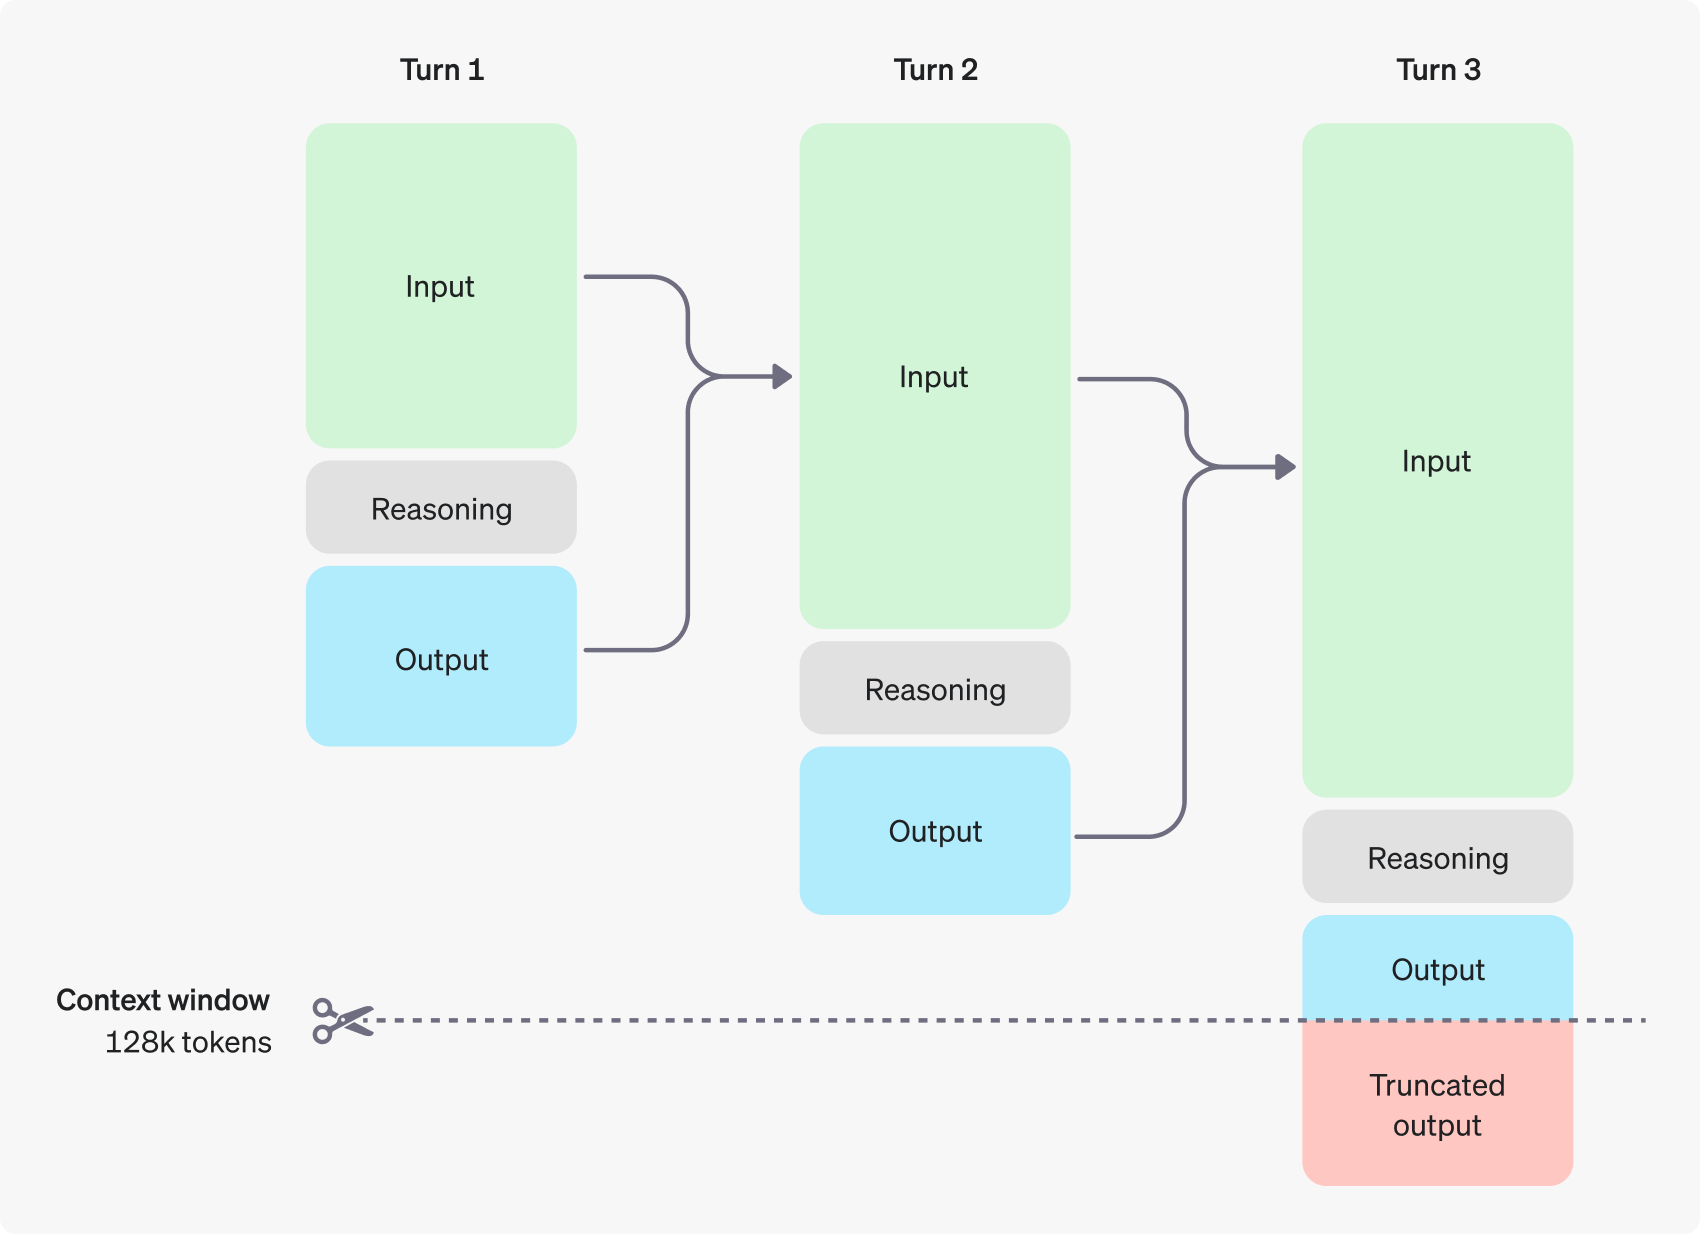


### When to use Reasoning models?

Here is a list of use cases and tasks that can benefit from reasoning models:

- Finding relationships and answer questions on large complex datasets (e.g., large set of distinct documents) in technical domains
- Reviewing, understanding, and debugging large codebases; it's also great at algorithmic development and scientific coding
- Scientific tasks that might require advanced mathematical problem-solving, experimental design and deeper reasoning 
- Literature reviewing & synthesis
- Routine generation for KBs to optimize the step-by-step instructions for LLMs ([example](https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation))
- Data validation to improve quality and reliability of datasets ([example](https://cookbook.openai.com/examples/o1/using_reasoning_for_data_validation))
- LLM-as-a-judge
- Multi-step agentic planning
- Recognizing and extracting relevant information for QA systems
- Knowledge-intensive and ambiguous tasks
- Visual reasoning
